<a href="https://colab.research.google.com/github/mlartorg/visualML/blob/master/lucid_stylegan2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/NVlabs/stylegan2

fatal: destination path 'stylegan2' already exists and is not an empty directory.


In [2]:
%cd /content/stylegan2
%tensorflow_version 1.x


/content/stylegan2
TensorFlow 1.x selected.


In [3]:
# settings

layer = 'mixed5b'
neuron = 1
iter_n = 100

In [4]:
import pretrained_networks

import numpy as np

import dnnlib

import tensorflow as tf

import dnnlib.tflib as tflib

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

import imageio

import sys





class StyleGanGenerator:
    def __init__(self):
        self.num_steps                  = 1000
        self.dlatent_avg_samples        = 10000
        self.initial_learning_rate      = 0.1
        self.initial_noise_factor       = 0.05
        self.lr_rampdown_length         = 0.25
        self.lr_rampup_length           = 0.05
        self.noise_ramp_length          = 0.75
        self.regularize_noise_weight    = 1e5
        self.verbose                    = False
        self.clone_net                  = True

        self._Gs                    = None
        self._minibatch_size        = None
        self._dlatent_avg           = None
        self._dlatent_std           = None
        self._noise_vars            = None
        self._noise_init_op         = None
        self._noise_normalize_op    = None
        self._dlatents_var          = None
        self._noise_in              = None
        self._dlatents_expr         = None
        self._images_expr           = None
        self._target_images_var     = None
        self._lpips                 = None
        self._dist                  = None
        self._loss                  = None
        self._reg_sizes             = None
        self._lrate_in              = None
        self._opt                   = None
        self._opt_step              = None
        self._cur_step              = None


    def set_network(self, Gs, minibatch_size=1):
        assert minibatch_size == 1
        self._Gs = Gs
        self._minibatch_size = minibatch_size
        if self._Gs is None:
            return
        if self.clone_net:
            self._Gs = self._Gs.clone()

        # Find dlatent stats.
        #self._info('Finding W midpoint and stddev using %d samples...' % self.dlatent_avg_samples)
        latent_samples = np.random.RandomState(123).randn(self.dlatent_avg_samples, *self._Gs.input_shapes[0][1:])
        dlatent_samples = self._Gs.components.mapping.run(latent_samples, None)[:, :1, :] # [N, 1, 512]
        self._dlatent_avg = np.mean(dlatent_samples, axis=0, keepdims=True) # [1, 1, 512]
        self._dlatent_std = (np.sum((dlatent_samples - self._dlatent_avg) ** 2) / self.dlatent_avg_samples) ** 0.5
        #self._info('std = %g' % self._dlatent_std)

        # Find noise inputs.
        #self._info('Setting up noise inputs...')
        self._noise_vars = []
        noise_init_ops = []
        noise_normalize_ops = []
        while True:
            n = 'G_synthesis/noise%d' % len(self._noise_vars)
            if not n in self._Gs.vars:
                break
            v = self._Gs.vars[n]
            self._noise_vars.append(v)
            noise_init_ops.append(tf.assign(v, tf.random_normal(tf.shape(v), dtype=tf.float32)))
            noise_mean = tf.reduce_mean(v)
            noise_std = tf.reduce_mean((v - noise_mean)**2)**0.5
            noise_normalize_ops.append(tf.assign(v, (v - noise_mean) / noise_std))
            #self._info(n, v)
        self._noise_init_op = tf.group(*noise_init_ops)
        self._noise_normalize_op = tf.group(*noise_normalize_ops)

        # Image output graph.
        #self._info('Building image output graph...')
        self._dlatents_var = tf.Variable(tf.zeros([self._minibatch_size] + list(self._dlatent_avg.shape[1:])), name='dlatents_var')
        self._noise_in =  self._dlatent_std * self.initial_noise_factor
        dlatents_noise = 0 #tf.random.normal(shape=self._dlatents_var.shape) * self._noise_in
        self._dlatents_expr = tf.tile(self._dlatents_var + dlatents_noise, [1, self._Gs.components.synthesis.input_shape[1], 1])
        self._images_expr = self._Gs.components.synthesis.get_output_for(self._dlatents_expr, randomize_noise=False)

        tflib.set_vars({self._dlatents_var: np.tile(self._dlatent_avg, [self._minibatch_size, 1, 1])})
        tflib.run(self._noise_init_op)




network_pkl = "gdrive:networks/stylegan2-ffhq-config-f.pkl"

_G, _D, Gs = pretrained_networks.load_networks(network_pkl)



sgg = StyleGanGenerator()
sgg.set_network(Gs)

generator_output = tf.transpose(sgg._images_expr,[0,2,3,1])

print(generator_output.shape)



model = models.InceptionV1()
model.load_graphdef()
#model.import_graph(generator_output,scope="import",forget_xy_shape=True)



# T = render.make_vis_T(model, "{}:{}".format(layer, neuron), param_f = generator_output, optimizer=tf.train.AdamOptimizer(0.05))

from lucid.optvis.objectives import deepdream

T = render.make_vis_T(model, deepdream(layer) * 100, param_f = generator_output, optimizer=tf.train.AdamOptimizer(0.05))



#tf.initialize_all_variables().run()

vis_op = T("optimizer").minimize(-1 * T("loss"),var_list=[sgg._dlatents_var])


#exit()

tf.variables_initializer([var for var in tf.global_variables() if ( "Adam" in var.name or "beta" in var.name )]).run()

for i in range(iter_n):

    print(i)
    vis_op.run()

    #output = T("input").eval()[0]
    #imageio.imwrite("output_{:02d}.png".format(i),output)



loss = T("loss").eval()
output = T("input").eval()[0]
imageio.imwrite("output_{}_{}__{:.2f}.png".format(layer, neuron,loss),output)


print("DONE WITH",neuron)

Setting up TensorFlow plugin "fused_bias_act.cu": Preprocessing... Loading... Done.
Setting up TensorFlow plugin "upfirdn_2d.cu": Preprocessing... Loading... Done.
(1, 1024, 1024, 3)
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


DONE WITH 1


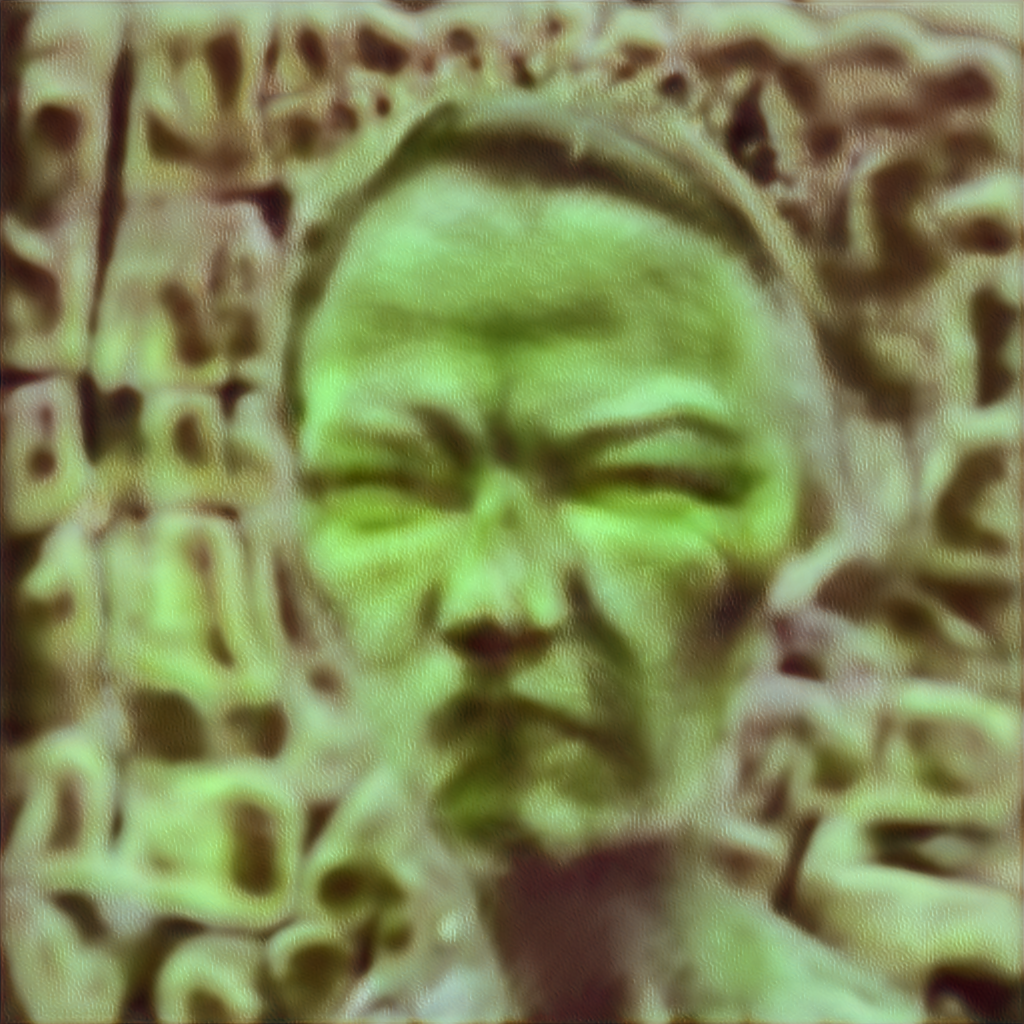

In [5]:
import PIL

PIL.Image.open("output_{}_{}__{:.2f}.png".format(layer, neuron,loss))
